# Basic model of ITD-tuned populations

This notebook explores a simple model of auditory neurons tuned to interaural time differences (ITD). Each neuron is attributed a Gaussian tuning curve with a preferred ITD (Gaussian mean) and spread (standard deviation). We will compute the Fisher information content of the population and create an encoder-decoder pipeline: for a fixed ITD, compute the population response, and estimate the ITD from it using maximum likelihood estimation (MLE).

- Our neurons have Gaussian tuning curves for ITD with shared spreads (~50 µs) and evenly spaced preferred ITDs over a fixed ITD domain (-200 to 200 µs)
- Responses follow independent Poisson point processes, which simplifies the calculation of the Fisher information
- Decoder uses maximum likelihood estimation to recover the ITD from the neural response, which is statistically efficient under these assumptions and basically the simplest decoder model that gives good predictions. In the future, we may explore more sophisticated decoding methods, such as generalized linear models (GLMs).
- Finally, we can optimize the population tuning parameter, sigma, to minimize decoding error under constrained total energy.

Below, we set up the population, specifying the number of neurons and their tuning parameters, compute response at a fixed ITD, and plot tuning curves, specific FI curves, and the population FI curve.

The rate of neuron $i$ is given by the Gaussian tuning curve over stimulus $s$:

$$ r_i(s) = r_0 + r_{\text{max}} \exp\left(-\frac{(s - \mu_i)^2}{2\sigma^2}\right) $$

where $\mu_i$ is the best ITD for neuron $i$, $\sigma$ controls the spread, $r_0$ is the spontaneous rate, and $r_{\text{max}}$ is the maximum firing rate (peak of the tuning curve).

Note that `GaussianTunedPopulation` is parameterized by a `reference_rate` $r_\text{ref}$ and `reference_sigma` $\sigma_\text{ref}$ at initialization, then we set the preferred stimulus, spread, and other parameters using the provided methods. The effective maximum rate $r_\text{max}$ (peak of the Gaussian tuning curve) is computed from the reference parameters and assigned spread $\sigma$ as follows.

$$ r_\text{max} = r_\text{ref} \frac{\sigma_\text{ref}}{\sigma} $$

This coupling of $\sigma$ to $r_\text{max}$ serves as a normalization condition, ensuring the integral of the tuning curve is constant across neurons.

For now, we consider an ITD domain of -200 to +200 microseconds.

### Fisher Information

Fisher information is a measure of the amount of information that an observable random variable carries about an unknown parameter upon which the probability distribution of the variable depends. In this case, the random variable is the spike train, and the unknown parameter is ITD $s$.


FI (per unit time) for a single Poisson neuron is equal to the slope of the tuning curve squared, divided by the rate:

$$ \frac{J_i(s)}{\Delta t} = \frac{\left( \frac{dr_i}{ds} \right)^2}{r_i(s)} $$

For a population of neurons, the total FI is the sum of individual FI values:

$$ \frac{J_\text{pop}(s)}{\Delta t} = \frac{1}{\Delta t} \sum_{i=1}^N J_i(s) $$

Although, we will not compute total FI over any particular time span. It is sufficient for our present analyses to consider the FI curve per unit time as a function of ITD $s$.

The population can resolve ITD differences better where neurons have high FI values across the relevant ITD range.

ITD has units of µs, $r(s)$ has units of Hz, so $J/\Delta t$ has units of $\text{µs}^{-2}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurostatsmodels.populations import GaussianTunedPopulation
np.set_printoptions(precision=4, suppress=True, linewidth=1000)

# import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', None)
# pd.set_option('display.float_format', '{:.4f}'.format)
# pd.set_option('display.expand_frame_repr', False)

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:200% !important; }</style>"))

In [2]:
# Create population
n_neurons = 10
pop = GaussianTunedPopulation(n_neurons=n_neurons, reference_rate=50.0, reference_sigma=30.0)

# Set up stimulus grid
stimulus_grid = np.linspace(-200, 200, 401)

# Configure population
pop.set_means_uniform(stimulus_grid)
pop.set_sigmas(30.0)   # set all neurons to same sigma (method also accepts a list)
pop.set_spontaneous_rates(2.0)   # baseline firing rate (method also accepts a list)

# Build curves on the grid
pop.build_tuning_curves(stimulus_grid)
pop.build_fisher_info_curves(epsilon=1e-10)   # add small epsilon to avoid division by zero

# Now query at specific points (works for single values!)
single_stimulus = 50.0    # example ITD
single_rates = pop.get_rates_at(single_stimulus)
single_fi = pop.get_population_fisher_info_at(single_stimulus)

print(f"At stimulus = {single_stimulus}:")
print(f"Rates: {single_rates}")
print(f"Population FI: {single_fi:.4f}")

At stimulus = 50.0:
Rates: [ 2.      2.      2.      2.0249  4.5895 34.3453 45.3714  8.3268  2.1094  2.0002]
Population FI: 0.0743


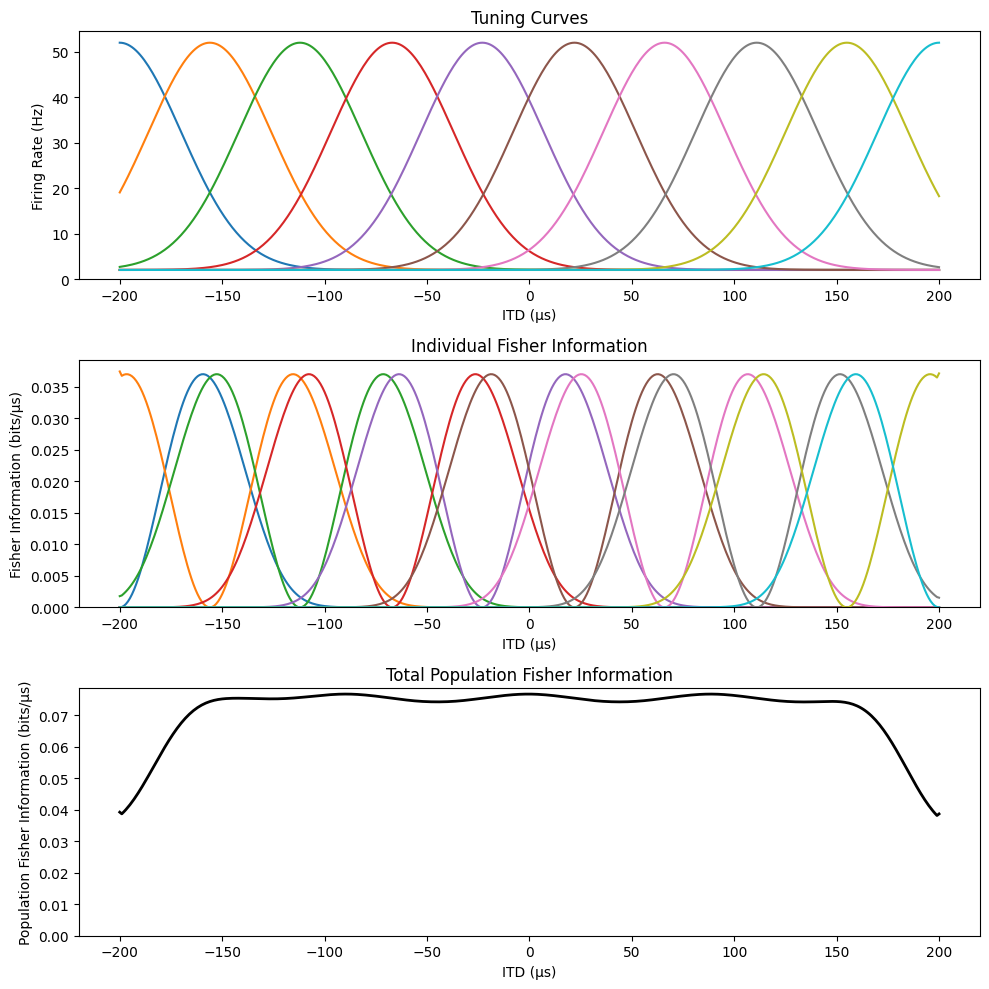

In [3]:
# Plot using stored curves (access TsdFrame correctly)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Tuning curves - access TsdFrame columns
for i in range(n_neurons):
    axes[0].plot(stimulus_grid, pop.tuning_curves.values[:, i])
axes[0].set_xlabel("ITD (µs)")
axes[0].set_ylabel("Firing Rate (Hz)")
axes[0].set_title("Tuning Curves")
axes[0].set_ylim(bottom=0)

# Individual FI - access TsdFrame columns
for i in range(n_neurons):
    axes[1].plot(stimulus_grid, pop.fisher_info_curves.values[:, i])
axes[1].set_xlabel("ITD (µs)")
axes[1].set_ylabel("Fisher Information (bits/µs)")
axes[1].set_title("Individual Fisher Information")
axes[1].set_ylim(bottom=0)

# Population FI - sum across neurons (axis 1)
pop_fi_curve = np.sum(pop.fisher_info_curves.values, axis=1)
axes[2].plot(stimulus_grid, pop_fi_curve, "k", linewidth=2)
axes[2].set_xlabel("ITD (µs)")
axes[2].set_ylabel("Population Fisher Information (bits/µs)")
axes[2].set_title("Total Population Fisher Information")
axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

Next, we use the population class `generate_spikes` method to generate spike times for each neuron in the population. I'm using the `TsGroup` class from `Pynapple` to store population spike times.

I have also implemented an absolute refractory period.

Spikes TsGroup:
      rate    mean     sigma    reference_rate    reference_sigma    refractory_period    spontaneous_rate
0    3       -200     30       50                30                 0                    2
1    2.6     -155.56  30       50                30                 0                    2
2    3.8     -111.11  30       50                30                 0                    2
3    2.2     -66.67   30       50                30                 0                    2
4    2.6     -22.22   30       50                30                 0                    2
5    31.6    22.22    30       50                30                 0                    2
6    34.2    66.67    30       50                30                 0                    2
7    8.8     111.11   30       50                30                 0                    2
8    2       155.56   30       50                30                 0                    2
9    2.4     200      30       50                30       

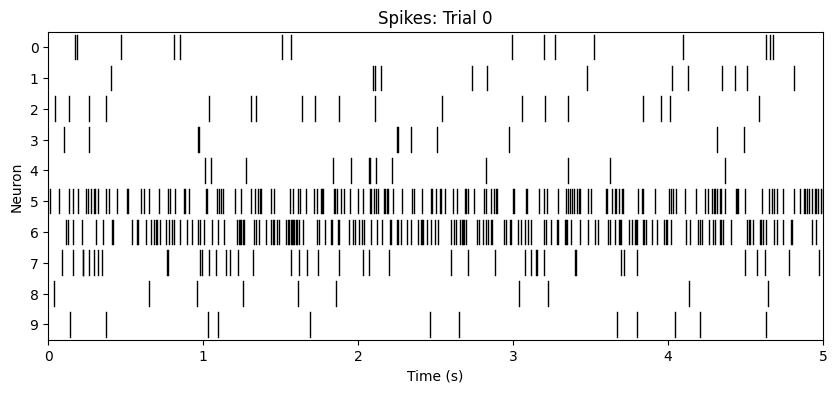

In [4]:
from neurostatsmodels.populations import GaussianTunedPopulation
from neurostatsmodels.plotting import plot_spike_raster

# Generate spikes (returns TsGroup)
pop = GaussianTunedPopulation(n_neurons=10, reference_rate=50., reference_sigma=30)
pop.set_means_uniform(np.linspace(-200, 200, 100))
pop.set_sigmas(30.0)
pop.set_refractory_periods(0.005)   # ARP in seconds
pop.set_spontaneous_rates(2.0)
spikes = pop.generate_spikes(50.0, duration=5.0, n_trials=1, dt=0.001, alpha=0.0)

print("Spikes TsGroup:\n", spikes._metadata)

# Plot trial 1 using new API
fig, ax = plot_spike_raster(spikes, trial_idx=0, title="Spikes: Trial 0")

The above plot shows the population model's encoding of a fixed ITD. Neuron indices are shown on the y-axis. Note that the rate of this sample is consistent with the tuning curve values at the given ITD.

Next, we compute a number of trials from the population model for a fixed ITD, and then decode using a MLE model to predict the ITD. The result is shown as a histogram of ITD predictions.

Bias: 0.28, Std: 3.88


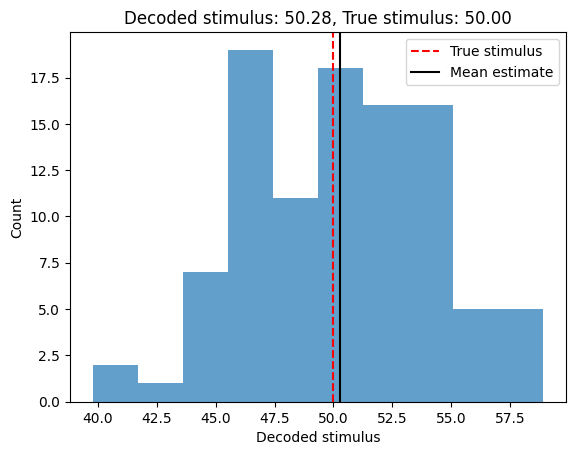

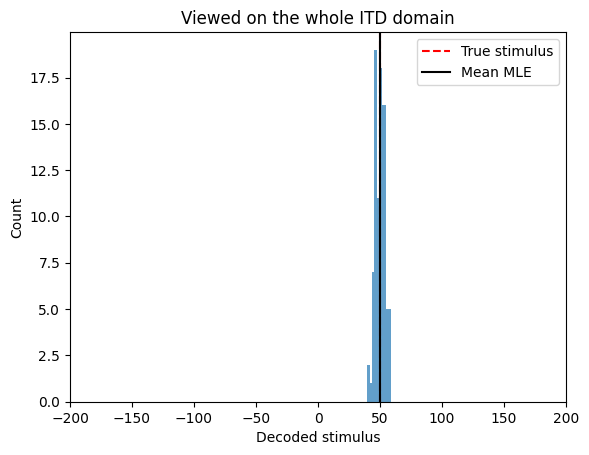

Average ITD error: 3.18 µs


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from neurostatsmodels.populations import GaussianTunedPopulation

# Create population
pop = GaussianTunedPopulation(n_neurons=10, reference_rate=50.0, reference_sigma=30.0)
pop.set_means_uniform(np.linspace(-200, 200, 100))
pop.set_sigmas(30.0)
pop.set_spontaneous_rates(2.0)
pop.set_refractory_periods(0.01)

# Generate spikes at true stimulus = 0 (returns TsGroup)
true_stimulus = 50.0
spikes = pop.generate_spikes(true_stimulus, duration=1.0, n_trials=100)
# Decode each trial using new API (no duration parameter)
s_hat = pop.decode_mle(spikes)

# Analyze bias and spread
bias = np.mean(s_hat) - true_stimulus
std = np.std(s_hat)
print(f"Bias: {bias:.2f}, Std: {std:.2f}")

n_bins = np.sqrt(len(s_hat)).astype(int)

# Plot histogram
plt.hist(s_hat, bins=n_bins, alpha=0.7)
plt.axvline(true_stimulus, color="r", linestyle="--", label="True stimulus")
plt.axvline(np.mean(s_hat), color="k", linestyle="-", label="Mean estimate")
plt.xlabel("Decoded stimulus")
plt.ylabel("Count")
plt.legend()
plt.title(f"Decoded stimulus: {np.mean(s_hat):.2f}, True stimulus: {true_stimulus:.2f}")
plt.show()

# zoom out
plt.hist(s_hat, bins=n_bins, alpha=0.7)
plt.axvline(true_stimulus, color="r", linestyle="--", label="True stimulus")
plt.axvline(np.mean(s_hat), color="k", linestyle="-", label="Mean MLE")
plt.xlabel("Decoded stimulus")
plt.ylabel("Count")
plt.legend()
plt.title(f"Viewed on the whole ITD domain")
plt.xlim(-200, 200)
plt.show()

# print average error
print(f"Average ITD error: {np.mean(np.abs(s_hat - true_stimulus)):.2f} µs")

#### Optimize tuning curve to maximize ITD decoding performance under firing rate budget using MLE decoder

The following cell implements the optimization of ITD decoding performance under firing rate budget using MLE decoder (varying sigma).

Note: At the time of writing, I haven't put *too* much effort into this code, and results may vary. The important conceptual point is that there exists optimal (in terms of decoder performance) tuning parameter values for a population of homogeneous neurons under a fixed metabolic budget. And, in principle, they can be computed with a constained optimization algorithm like COBYLA. 

In [9]:
import numpy as np
from scipy.optimize import minimize
from neurostatsmodels.populations import GaussianTunedPopulation

# Fixed parameters
n_neurons = 10
reference_rate = 50.0  # Hz, same for all neurons
reference_sigma = 30.0  # Hz, same for all neurons
spontaneous_rate = 3.0  # Hz, baseline firing rate
refractory_period = 0.005  # 5 ms refractory period
itd_range = (-200, 200)  # microseconds
n_itd_steps = 401
rate_budget = 200.0  # Total average firing rate across population (Hz)

# ITD range in microseconds
itd_min, itd_max = itd_range
itd_grid = np.linspace(itd_min, itd_max, n_itd_steps)

# Initialize population
pop = GaussianTunedPopulation(
    n_neurons=n_neurons, reference_rate=reference_rate, reference_sigma=reference_sigma
)

# Set fixed parameters
pop.set_spontaneous_rates(spontaneous_rate)
pop.set_refractory_periods(refractory_period)

# Distribute neuron means uniformly across ITD range
pop.set_means_uniform(itd_grid)

print(f"Population setup:")
print(f"  Neurons: {n_neurons}")
print(f"  Reference rate: {reference_rate} Hz")
print(f"  Reference sigma: {reference_sigma} Hz")
print(f"  Spontaneous rate: {spontaneous_rate} Hz")
print(f"  Refractory period: {refractory_period*1000} ms")
print(f"  ITD range: {itd_min} to {itd_max} μs")
print(f"  Rate budget: {rate_budget} Hz")
print(f"  Neuron preferred ITDs: {pop.means}")
print()


def objective_and_constraint(
    sigma, n_test_stimuli=10, n_trials_per_stim=100, trial_duration=5.0, random_seed=42
):
    """
    Compute MSE from MLE decoding and rate constraint violation.

    Parameters
    ----------
    sigma : float
        Tuning curve width shared for all neurons.
    n_test_stimuli : int
        Number of test ITD values to sample.
    n_trials_per_stim : int
        Number of trials per stimulus for decoding.
    trial_duration : float
        Duration of each trial in seconds.
    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    mse : float
        Mean squared error of MLE decoder predictions.
    rate_violation : float
        Constraint violation (should be <= 0).
    """
    # Set sigmas
    if np.isscalar(sigma):
        pop.set_sigmas(sigma)
    else:
        pop.set_sigmas(sigma[0])

    # Build tuning curves for decoding
    pop.build_tuning_curves(itd_grid)

    # Sample test ITD values uniformly from range
    rng = np.random.default_rng(random_seed)
    test_itds = rng.uniform(itd_min, itd_max, n_test_stimuli)

    # Generate spikes and decode for each test ITD
    squared_errors = []
    spreads = []

    for true_itd in test_itds:
        # Generate spikes for this ITD
        spikes = pop.generate_spikes(
            stimulus=true_itd,
            duration=trial_duration,
            n_trials=n_trials_per_stim,
            random_state=rng,
        )

        # Decode using MLE
        decoded_itds = pop.decode_mle(spikes, stimulus_range=itd_range)

        # Compute squared errors for all trials
        squared_errors.append((decoded_itds - true_itd) ** 2)
        spreads.append(np.std(decoded_itds))
    
    # Compute error metrics
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)  
    avg_spread = np.mean(spreads)

    objective = rmse  # define objective here

    # Compute average firing rate across population and ITD range
    rates = pop.compute_rates(itd_grid)  # shape: (n_neurons, n_itd)
    avg_rate_per_neuron = np.mean(rates, axis=1)  # average over ITD
    total_avg_rate = np.sum(avg_rate_per_neuron)  # sum over neurons

    # if total_avg_rate < rate_budget, then constraint is positive -> GOOD
    # if total_avg_rate > rate_budget, then constraint is negative -> BAD
    constraint = rate_budget - total_avg_rate

    # Return objective and constraint violation
    return objective, constraint


def objective(sigma):
    """Objective function: MSE from MLE decoding."""
    objective, _ = objective_and_constraint(sigma)
    return objective


def constraint_func(sigma):
    """Constraint function: rate budget - total rate (should be >= 0)."""
    _, constraint = objective_and_constraint(sigma)
    return constraint  # should be positive

Population setup:
  Neurons: 10
  Reference rate: 50.0 Hz
  Reference sigma: 30.0 Hz
  Spontaneous rate: 3.0 Hz
  Refractory period: 5.0 ms
  ITD range: -200 to 200 μs
  Rate budget: 200.0 Hz
  Neuron preferred ITDs: [-200. -156. -112.  -67.  -23.   22.   66.  111.  155.  200.]



100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


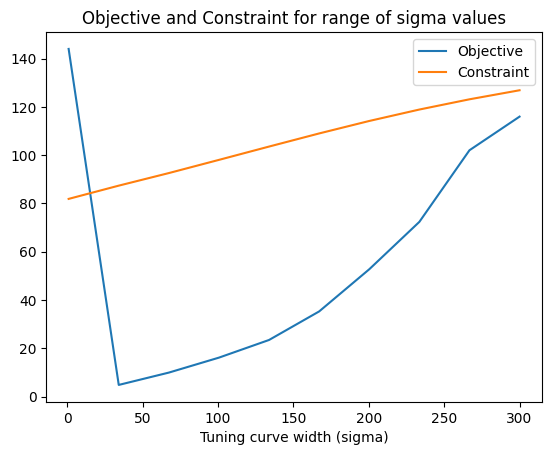

In [ ]:
# plot objective function for range of sigma values
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

sigma_range = np.linspace(1, 200, 10)
obj_list = []
const_list = []
for sigma in tqdm(sigma_range):
    obj, const = objective_and_constraint(sigma, n_trials_per_stim=10, trial_duration=1)
    obj_list.append(obj)
    const_list.append(const)

plt.figure()
plt.plot(sigma_range, obj_list, label="Objective")
plt.plot(sigma_range, const_list, label="Constraint")
plt.legend()
plt.title("Objective and Constraint for range of sigma values")
plt.xlabel("Tuning curve width (sigma)")
plt.show()

Above I have plotted the objective and constraint value for a range of tuning curve widths (standard deviation of the Gaussian). 
The objective is the RMSE of the MLE estimator, and the constraint is the total rate budget minus the sum of firing rates (averaged over trials).

The constraint value is always positive, so the budget condition is satisfied.
For small sigma, the neurons are too narrowly tuned and thus do not spike much. 
For very large sigma, the neurons are too broad and thus all spike often, meaning the population is not informative.
There is an optimal sigma that balances these two effects.

The final cell performs a proper optimization of the above model, but it is really slow. 
This important conceptual takeaway is that such optimization is possible.

In [ ]:

# Initial guess: uniform sigmas
sigma_init = 50

# Bounds: sigmas must be positive and reasonable
sigma_bounds = [(1.0, 200.0)]

# Constraint: total average firing rate <= rate_budget
constraints = {"type": "ineq", "fun": constraint_func}

print("Starting optimization...")
print(f"Initial sigma: {sigma_init}")

# Evaluate initial objective
print("Evaluating initial objective (this may take a moment)...")
initial_objective, _ = objective_and_constraint(sigma_init)
pop.set_sigmas(sigma_init)
initial_rate = np.sum(np.mean(pop.compute_rates(itd_grid), axis=1))

print(f"Initial objective: {initial_objective:.2f}")
print(f"Initial total rate: {initial_rate:.2f} Hz")
print()

# Optimize
result = minimize(
    objective,
    sigma_init,
    method="COBYLA",
    bounds=sigma_bounds,
    constraints=constraints,
    options={"maxiter": 200, "disp": True},
)

print("Optimization complete!")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
# print(f"Iterations: {result.nit}")
print()

# Extract optimal sigma
optimal_sigma = result.x[0]

# Evaluate final objective
print("Evaluating final objective...")
final_objective, _ = objective_and_constraint(optimal_sigma)
pop.set_sigmas(optimal_sigma)
final_rate = np.sum(np.mean(pop.compute_rates(itd_grid), axis=1))

print(f"Optimal sigma: {optimal_sigma}")
print(f"Final objective: {final_objective:.2f}")
print(f"Final total rate: {final_rate:.2f} Hz")
print(f"Objective improvement: {(1 - final_objective/initial_objective)*100:.2f}%")
print()

# Display results
print("Neuron-by-neuron summary:")
print(f"{'Neuron':<8} {'Mean (μs)':<12} {'Sigma (μs)':<12} {'Avg Rate (Hz)':<15}")
print("-" * 50)
rates = pop.compute_rates(itd_grid)
for i in range(n_neurons):
    avg_rate = np.mean(rates[i, :])
    print(f"{i:<8} {pop.means[i]:<12.2f} {optimal_sigma:<12.2f} {avg_rate:<15.2f}")

print()
print(f"Total average rate: {final_rate:.2f} Hz (budget: {rate_budget} Hz)")
print(f"Decoding objective: {final_objective:.2f}")